In [2]:
#Import packages
import pandas as pd
import numpy as np
import glob

from functions import plotting_raw_data, remove_outliers, error_plot, plot_cpt_data, plot_cpt_data_ML_prediction, plot_cpt_data_NW_site

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import r2_score
import xgboost as xgb

import optuna
from optuna.samplers import TPESampler
from optuna.visualization import plot_param_importances, plot_optimization_history

c:\Users\haris\Documents\GitHub\ISGSR25_DataDrivenSiteCharacterization\DataDriven\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
######################## Define the text size of each plot globally ###########
SMALL_SIZE = 10
BIGGER_SIZE = 10

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

plt.rcParams["font.family"] = "Times New Roman"
cm = 1/2.54  # centimeters in inches

In [16]:
# =============================================================================
# Import Dataset
# =============================================================================
path = r"..\data\soil_parameter\\"
file_list = glob.glob(path + "/*.xlsx")
data_list = []

for file in file_list:
    try:
        # Attempt to read the first sheet
        data = pd.read_excel(file, sheet_name=0)
        data_list.append(data)
    except ValueError as e:
        print(f"Error reading file: {file}\nError: {e}")
    except Exception as e:
        print(f"Unexpected error with file: {file}\nError: {e}")

# Merge all successfully read data
if data_list:
    data_merged = pd.concat(data_list, ignore_index=True)
    print("Data merged successfully.")
else:
    print("No data to merge.")

Data merged successfully.


In [17]:
data_merged

,sampling_name (-),sampling_depth (m),sampling_corr_depth (m),sampling_unitweight (kN/m3),sampling_Oed_type (-),sampling_M (MN/m2),sampling_OCR (-),sampling_Strength_type TRIAX (-),sampling_su (kN/m2),sampling_Strength_type DSS (-),...,"Corr_su (Nkt, Lunne 2005)","Corr_su (Nke, Mayne 2008)","Corr_su (Ndeltau, Lunne 2010)",Unnamed: 49,Unnamed: 50,Unnamed: 51,sampling_Strength_type (-),Unnamed: 47,Unnamed: 48,Unnamed: 35
0,Bergambacht (B06 49B),1.60,NaN,10.750000,NaN,NaN,NaN,NaN,NaN,False,...,NaN,NaN,NaN,NaN,Nkt,12.0,NaN,NaN,NaN,NaN
1,Bergambacht (B06 51B),3.00,NaN,10.370000,NaN,NaN,1.830000,NaN,NaN,False,...,NaN,NaN,NaN,NaN,Nke,8.0,NaN,NaN,NaN,NaN
2,Bergambacht (B06 51C),3.20,NaN,10.390000,NaN,NaN,NaN,NaN,NaN,False,...,NaN,NaN,NaN,NaN,Ndeltau,6.0,NaN,NaN,NaN,NaN
3,Bergambacht (B06 52B),4.05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Bergambacht (B06 52C),4.25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1123,PTS_Seekirchen_CC12,4.40,4.55,17.849941,IL,2.203390,2.058824,NaN,NaN,NaN,...,35.910833,26.90,44.668333,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1124,PTS_Seekirchen_CC12,4.40,4.55,16.930067,CRS,1.950510,2.156863,NaN,NaN,NaN,...,35.910833,26.90,44.668333,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1125,PTS_Seekirchen_CC12,4.40,4.55,16.900000,NaN,NaN,NaN,NaN,NaN,NaN,...,35.910833,26.90,44.668333,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1126,PTS_Seekirchen_CC32,4.40,4.65,17.237443,IL,2.076677,1.960784,NaN,NaN,NaN,...,36.600833,27.65,45.171667,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
data_merged.dropna(subset=['cptu_qc (MPa)'], inplace=True)

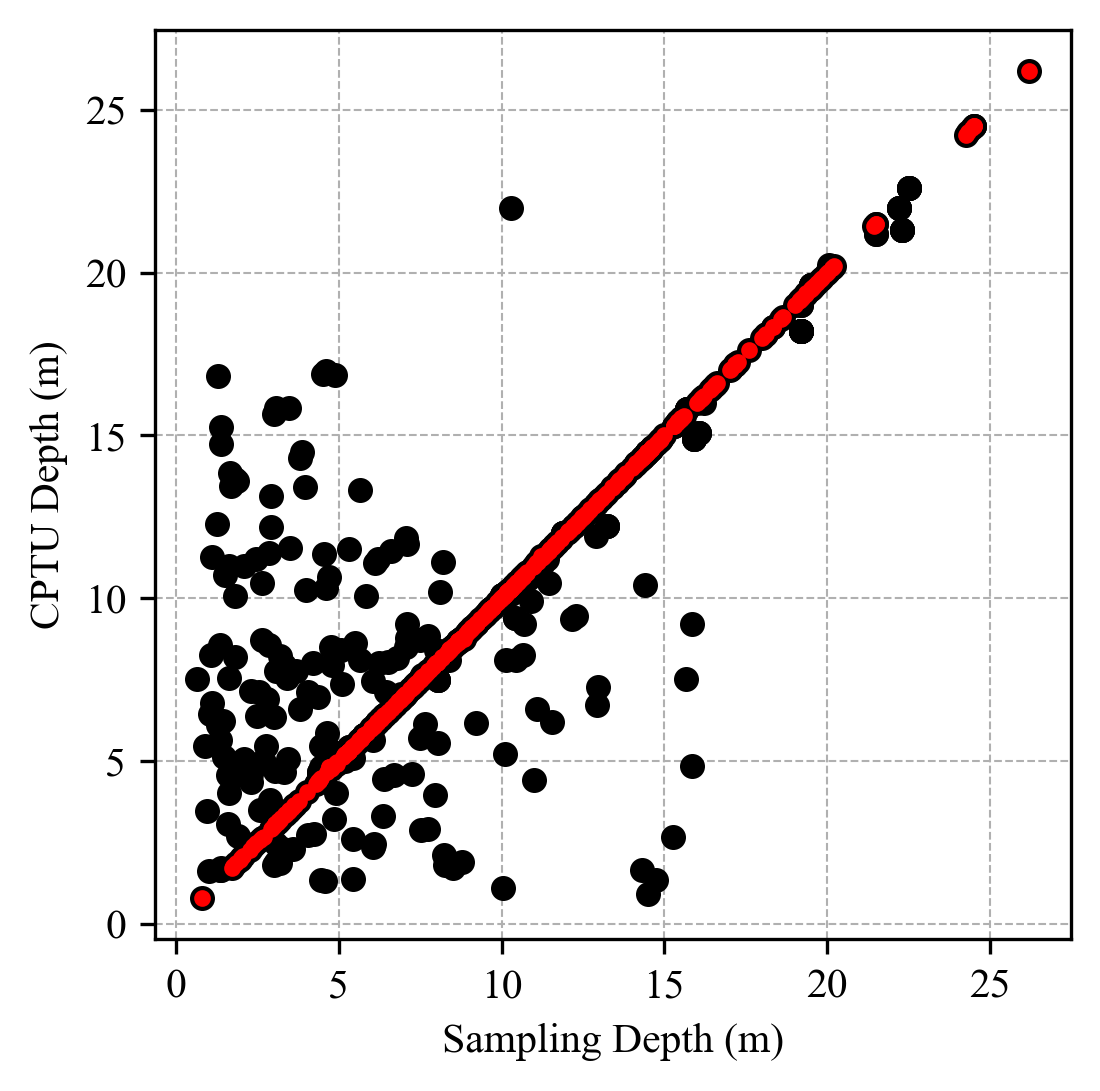

In [20]:
# # Select columns
selected_columns = ['sampling_name (-)','sampling_depth (m)','cptu_depth (m)','cptu_corr_depth (m)', 'cptu_qc (MPa)', 'cptu_fs (kPa)',
       'cptu_u2 (kPa)', 'cptu_Rf (%)',  'cptu_SBT', 'sampling_unitweight (kN/m3)','sampling_M (MN/m2)', 'sampling_OCR (-)', 'sampling_su (kN/m2)'] 

data = data_merged[selected_columns]
mismatch_1_2 = data[data['sampling_depth (m)'] != data['cptu_depth (m)']]

# Filter rows where the absolute difference is within 0.1m
filtered_data = data[abs(data['sampling_depth (m)'] - data['cptu_depth (m)']) <= 0.1]

plt.figure(dpi = 300, figsize = (10*cm,10*cm))
plt.plot(data['sampling_depth (m)'], data['cptu_depth (m)'], 'o', markersize = 5, color = 'black')
plt.xlabel('Sampling Depth (m)')
plt.ylabel('CPTU Depth (m)')
plt.plot(filtered_data['sampling_depth (m)'], filtered_data['cptu_depth (m)'], 'o', color = 'red', markersize = 3)
plt.grid(lw = 0.5, ls = '--')

selected_columns = ['cptu_depth (m)', 'cptu_qc (MPa)', 'cptu_fs (kPa)', 'cptu_Rf (%)', 'cptu_u2 (kPa)', 'sampling_unitweight (kN/m3)','sampling_M (MN/m2)', 'sampling_OCR (-)', 'sampling_su (kN/m2)', 'sampling_name (-)'] 
renamed_columns_x = ['Depth (m)','qc (MPa)', 'fs (kPa)','Rf (%)','u2 (kPa)', 'gamma (kN/m3)', 'M (MN/m2)', 'OCR (-)', 'su (kPa)', 'sampling_name(-)'] #for Machine learning features
data_ML = data[selected_columns]
data_ML.columns = renamed_columns_x


In [ ]:
data_ML.loc[:,'Rf (%)'] = data_ML.loc[:,'fs (kPa)']/(data_ML.loc[:,'qc (MPa)']*1000)*100

# List of sampling names to exclude
sampling_names_to_exclude = [
    'NGTS_QClay_TILB06',
    'NGTS_QClay_TILB17',
    'NGTS_QClay_TILB19',
]

# Replace sampling names that start with "NGTS" with new names
data_ML.loc[data_ML['sampling_name(-)'].str.startswith('PITS_Raggal'), 'sampling_name(-)'] = 'Austria_site1'
data_ML.loc[data_ML['sampling_name(-)'].str.startswith('PITS_Rhesi'), 'sampling_name(-)'] = 'Austria_site2'
data_ML.loc[data_ML['sampling_name(-)'].str.startswith('PITS_Seekirchen'), 'sampling_name(-)'] = 'Austria_site3'

data_ML.loc[data_ML['sampling_name(-)'].str.startswith('Project_Norway'), 'sampling_name(-)'] = 'Norway_site'

data_ML.loc[data_ML['sampling_name(-)'].str.startswith('Project_Salzburg'), 'sampling_name(-)'] = 'Austria_site4'
data_ML.loc[data_ML['sampling_name(-)'].str.startswith('PTS_Seekirchen'), 'sampling_name(-)'] = 'Austria_site5'
data_ML.loc[data_ML['sampling_name(-)'].str.startswith('Salzburg_Salzburg'), 'sampling_name(-)'] = 'Austria_site6'

# Exclude the rows from data_ML
data_ML = data_ML[~data_ML['sampling_name(-)'].isin(sampling_names_to_exclude)]

data_ML.to_csv(r'..\data\database_preprocessed_2024_soilparameter.csv', index = False)
data_ML

,Depth (m),qc (MPa),fs (kPa),Rf (%),u2 (kPa),gamma (kN/m3),M (MN/m2),OCR (-),su (kPa),sampling_name(-)
1,1.80,0.289,19.0,6.574394,37.0,10.370000,NaN,1.830000,NaN,Bergambacht (B06 51B)
2,1.86,0.289,19.0,6.574394,37.0,10.390000,NaN,NaN,NaN,Bergambacht (B06 51C)
3,2.71,0.257,14.0,5.447471,51.0,NaN,NaN,NaN,NaN,Bergambacht (B06 52B)
4,2.76,0.257,14.0,5.447471,51.0,NaN,NaN,NaN,NaN,Bergambacht (B06 52C)
5,1.35,0.226,11.0,4.867257,51.0,NaN,NaN,NaN,NaN,Bergambacht (B06 52D)
...,...,...,...,...,...,...,...,...,...,...
1123,4.55,0.480,7.5,1.562500,304.8,17.849941,2.203390,2.058824,NaN,Austria_site5
1124,4.55,0.480,7.5,1.562500,304.8,16.930067,1.950510,2.156863,NaN,Austria_site5
1125,4.55,0.480,7.5,1.562500,304.8,16.900000,NaN,NaN,NaN,Austria_site5
1126,4.65,0.490,7.7,1.571429,308.8,17.237443,2.076677,1.960784,NaN,Austria_site5


In [ ]:
# =============================================================================
# Import Dataset
# =============================================================================
path = r"..\data\soil_parameter\\"

import pandas as pd

file1 = r"..\data\database_preprocessed_2025_CPT.csv"
file2 = r"..\data\vs\compiled_database_NZGD.csv"
data_list = []
file_list = []
file_list.append(file1)
file_list.append(file2)

for file in file_list:
    try:
        # Attempt to read the first sheet
        data = pd.read_csv(file)
        data_list.append(data)
    except ValueError as e:
        print(f"Error reading file: {file}\nError: {e}")
    except Exception as e:
        print(f"Unexpected error with file: {file}\nError: {e}")

# Merge all successfully read data
if data_list:
    data_merged = pd.concat(data_list, ignore_index=True)
    print("Data merged successfully.")
else:
    print("No data to merge.")

data_merged.to_csv(r'..\data\database_preprocessed_2025_vs_2.csv', index = False)

C:\Users\haris\AppData\Local\Temp\ipykernel_19084\1048713005.py:18: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(file)


Data merged successfully.
